In [74]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import os
import sys
import configparser
sys.path.append(os.path.join('..'))
from physics215ProjectCode import reconstruct_signal as rs
from physics215ProjectCode import error_fn
from physics215ProjectCode import configParser as cP

Importing parameters

In [75]:
configpath = '../configs/config1.ini'
category = 'Figure1ExeSummary'

config = cP.parseConfig(configpath, category)

In [76]:
n = int(config['n']) # resolution of the original signal
initial_frequency = eval(config['initial_frequency']) # smallest frequency of the signal
increments = eval(config['increments']) # the spacing between two adjacent frequencies
final_frequency = eval(config['final_frequency']) # largest frequency of the signal
t_end = int(config['t_end']) # how long the signal is
t = np.linspace(0,t_end,n) # array for generating signal
p = eval(config['p']) # number of random points sampled from original signal for sub-nyquist reconstruction

In [77]:
frequencies = np.arange(initial_frequency, final_frequency + 1, increments) # frequencies of the signal just put in an array
frequency_x = np.arange(0,n) # for plotting PSD (in frequency space)

Generating the original signal:

We will generate multiple signals, depending on the initial frequency, final frequency, and the increments. For example, since the initial frequency is 600 Hz, the final frequency is 700 Hz, and the increment is 50 Hz, three signals will be generated. The first signal contains only the 600 Hz frequency. The second signal includes both 600 Hz and 650 Hz. Finally, the third signal combines all three frequencies: 600 Hz, 650 Hz, and 700 Hz.

Number of uniformly-spaced sample points for above Nyquist frequency sampling n = 2 * final_frequency = 1400 samples

In [78]:
orig_signal_per_f = []

for f_iter in frequencies:
    orig_signal_per_f.append(rs.make_signal(n, initial_frequency, f_iter, increments))

Power Spectral Density (PSD) of original signal:

Power spectral density is a measure of how the power of a signal or time series is distributed across different frequencies. In our signal, it has the frequencies 600, 650, and 700 Hz. So, we should expect peaks at those values.

In [79]:
PSD_orig = []

for signal_iter in orig_signal_per_f:
    PSD_orig.append(rs.PSD(signal_iter))

Plotting PSD of Original Signal:

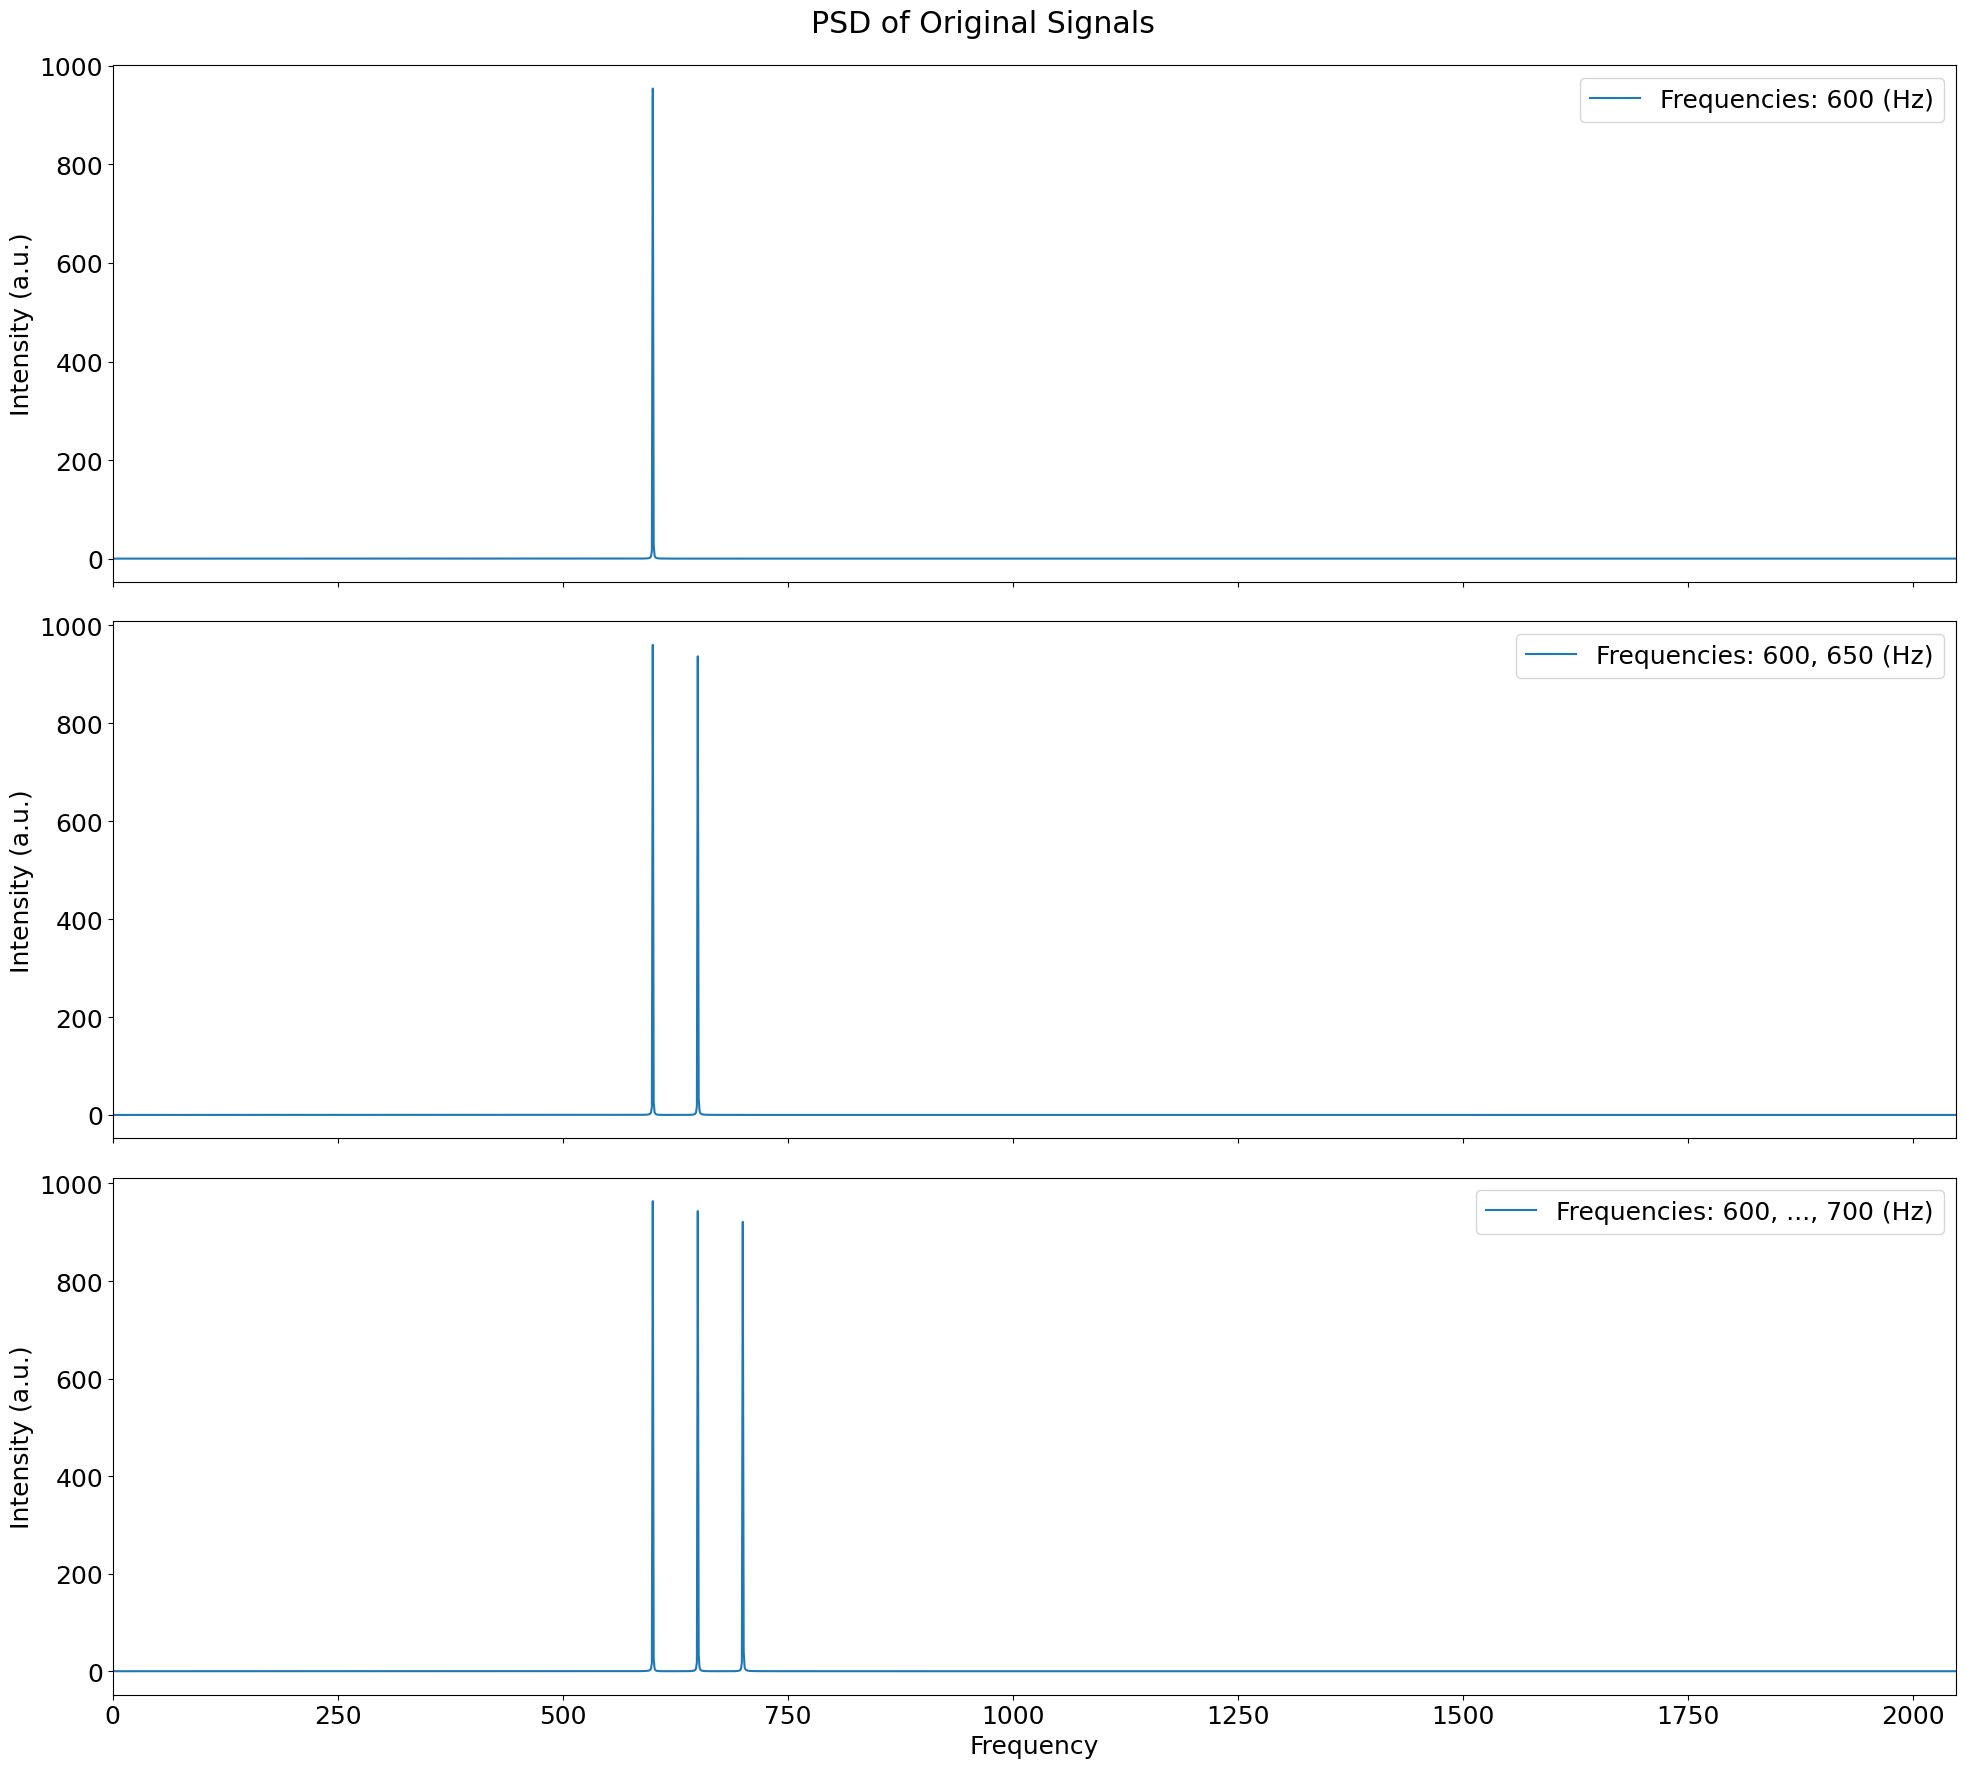

In [81]:
plt.rcParams['figure.figsize'] = [20, 12]
plt.rcParams.update({'font.size': 18})

fig,axs = plt.subplots(len(frequencies),1)
axs = axs.reshape(-1)
ylim = (-2,2)
ylim_uni = (ylim[0]*3000, ylim[1]*3000)
legend = "Frequencies: "

for i, pt in enumerate(frequencies):
    if i <= 1:
        if pt == initial_frequency:
            legend += str(pt)
        else:
            legend += ", " + str(pt)
    else:
        legend = "Frequencies: " + str(initial_frequency) + ", ..., " + str(pt)
    axs[i].plot(abs(PSD_orig[i]), label = legend + " (Hz)")
    axs[i].set_xlim(0,n/2) # hide the negaitve frequencies
    axs[i].set_ylabel("Intensity (a.u.)")
    axs[i].legend()
    if i != len(axs) - 1:
        axs[i].set_xticklabels([])  # Hide x-tick labels

fig.suptitle("PSD of Original Signals")
plt.xlabel("Frequency")
plt.tight_layout(rect=[0, -0.5, 1, 1.01])
plt.show()

Reconstructing the signal above Nyquist frequency:

In [ ]:
reg_recon_per_f = []

for f_iter in orig_signal_per_f:
    signal_recon = rs.nyquist_reconstruction(final_frequency * 2, f_iter) # reconstruction of signal

    # interpolate reconstructed signal to match resolution of original signal
    ## this will fix spacing issues of its PSD
    n_low = len(signal_recon)
    t_low = np.linspace(0, 1, n_low)
    interp_fn = interp1d(t_low, signal_recon, kind='cubic')
    signal_high = interp_fn(t)
    
    reg_recon_per_f.append(signal_high)

Acquiring PSD of above Nyquist reconstruction:

In [ ]:
PSD_reg = []

for signal_iter in reg_recon_per_f:
    PSD_reg.append(rs.PSD(signal_iter))

Reconstructing the signal sub-Nyquist:

In [ ]:
sub_recon_per_p = []

for p_iter in p: # repeat the process with different number of random samples, p
    sub_recon_per_f = []
    for f_iter in orig_signal_per_f:
        sub_recon_per_f.append(rs.sub_nyquist_reconstruction(p_iter, f_iter))
    sub_recon_per_p.append(sub_recon_per_f)

Acquiring PSD of sub-Nyquist reconstruction:

In [ ]:
PSD_sub = []

for p_iter in sub_recon_per_p: 
    PSD_sub_per_f = []
    for signal_iter in p_iter:
        PSD_sub_per_f.append(rs.PSD(signal_iter))
    PSD_sub.append(PSD_sub_per_f)

Plotting PSD of sub-Nyquist reconstruction:

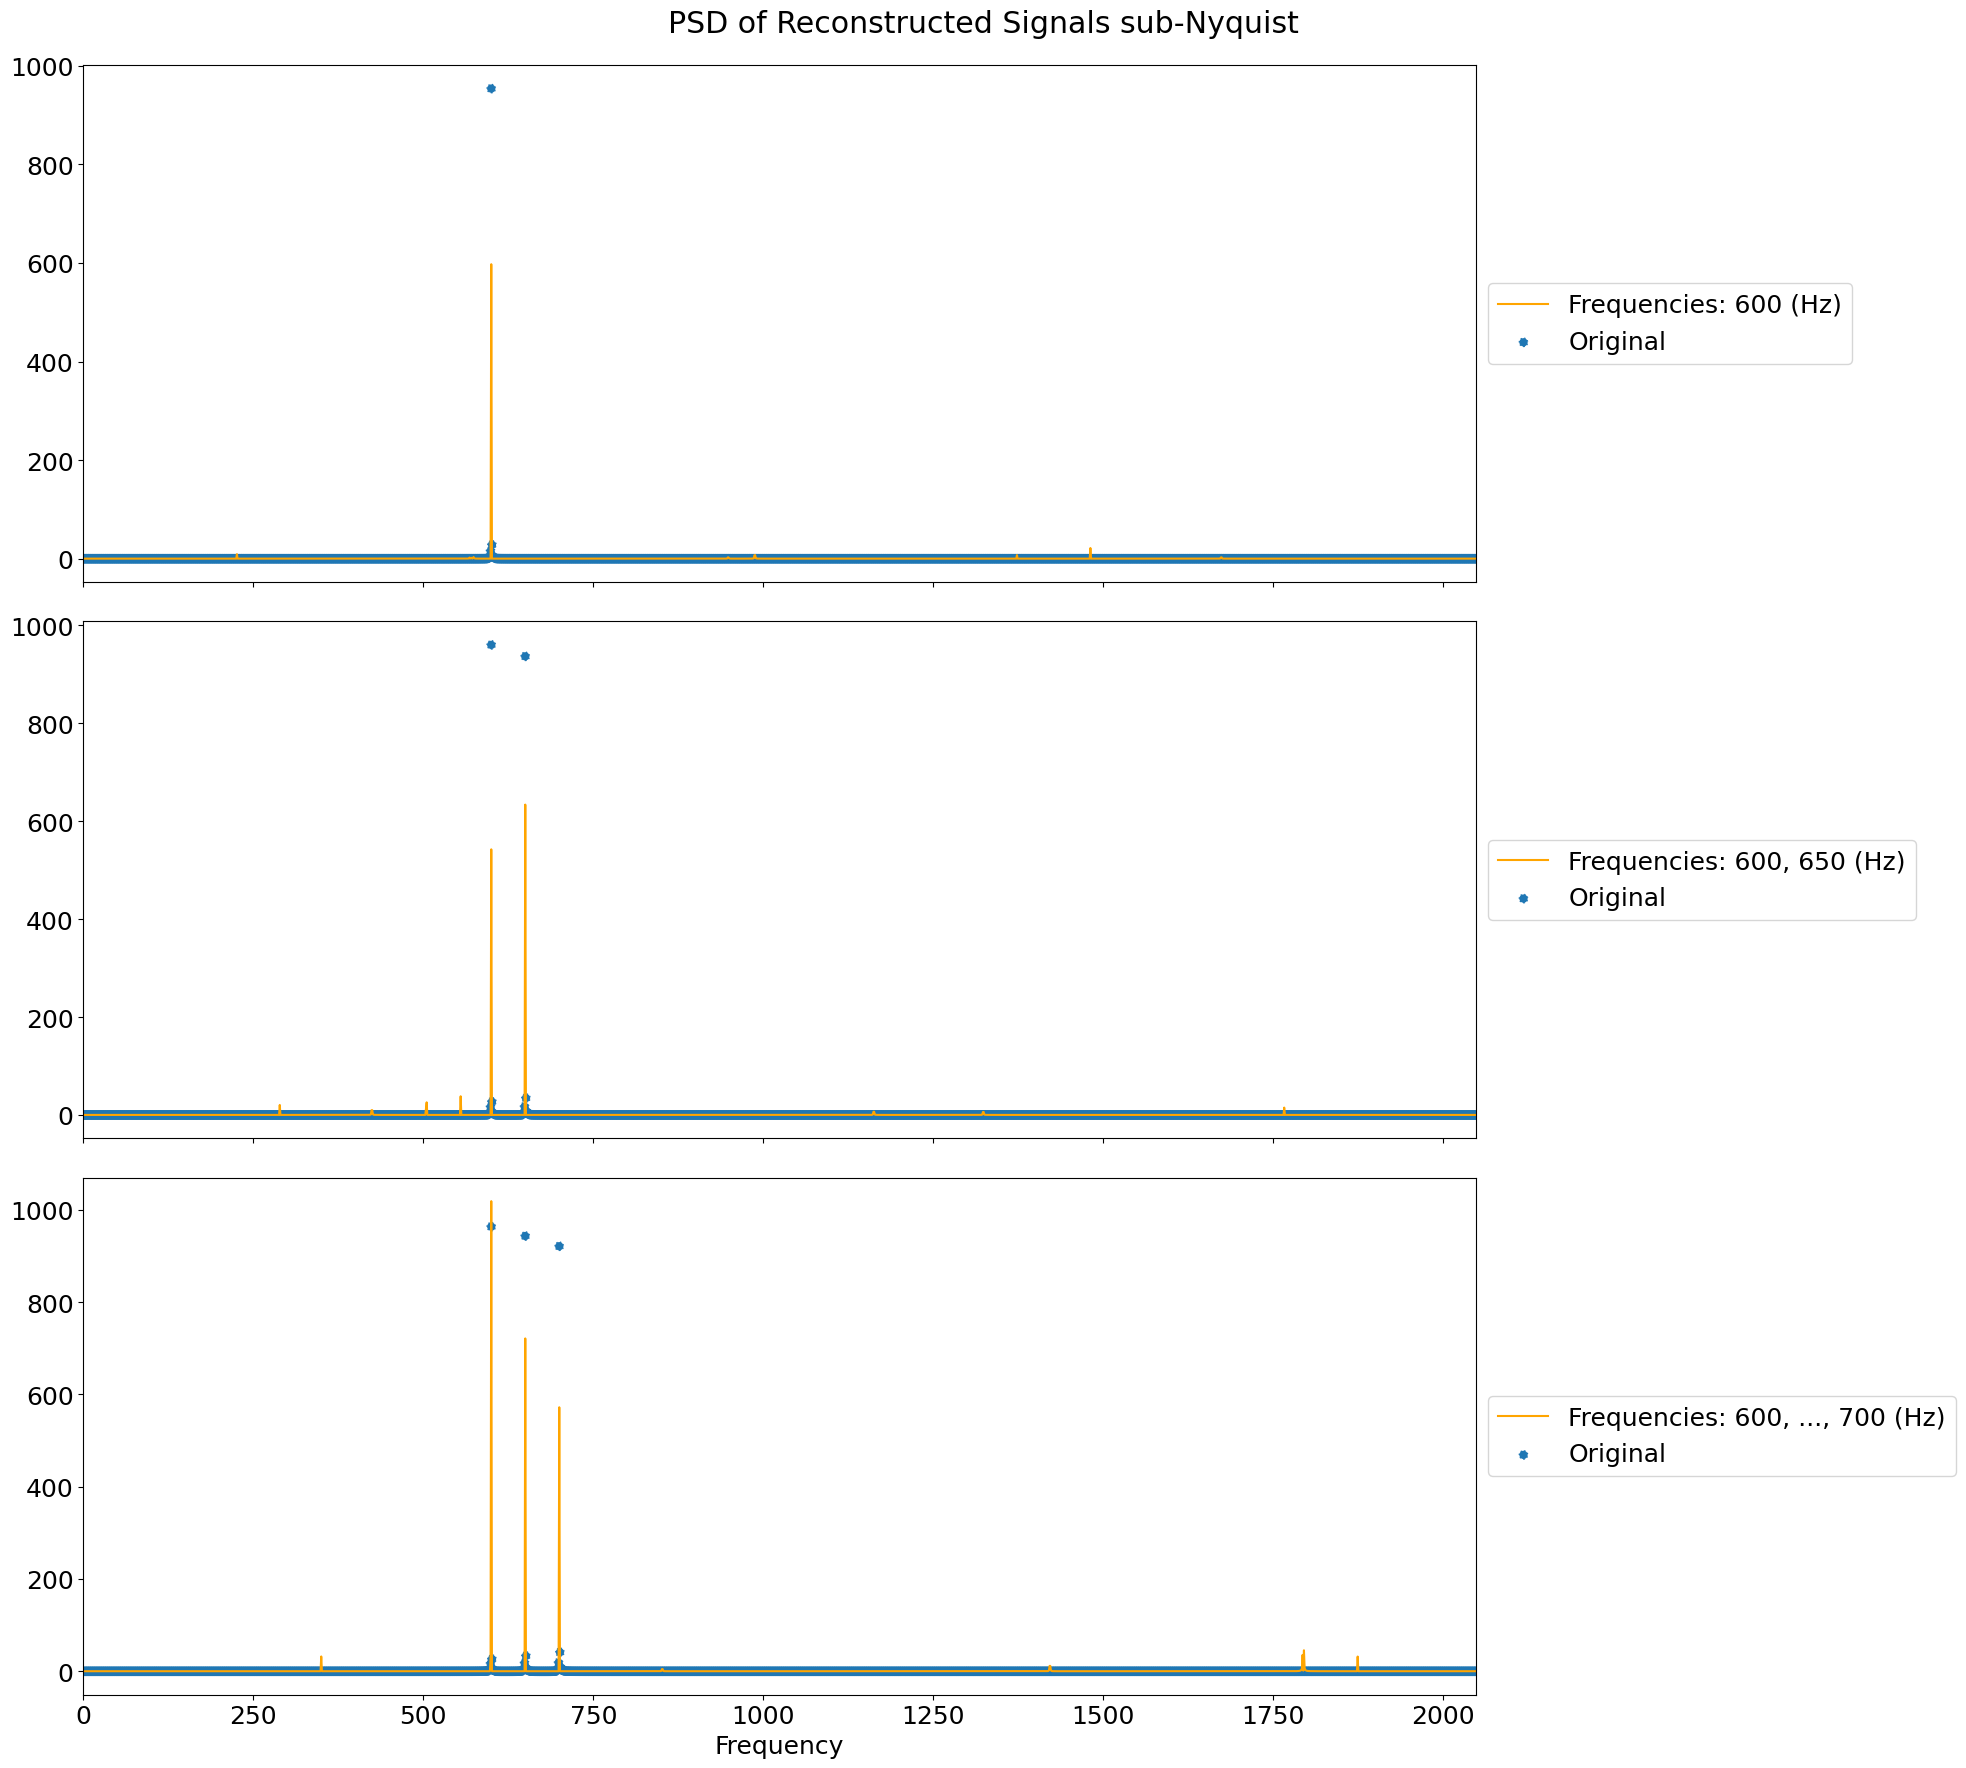

In [67]:
plt.rcParams['figure.figsize'] = [20, 12]
plt.rcParams.update({'font.size': 18})

fig,axs = plt.subplots(len(frequencies),1)
axs = axs.reshape(-1)
ylim = (-2,2)
ylim_uni = (ylim[0]*3000, ylim[1]*3000)
legend = "Frequencies: "

for i, pt in enumerate(frequencies):
    if i <= 1:
        if pt == initial_frequency:
            legend += str(pt)
        else:
            legend += ", " + str(pt)
    else:
        legend = "Frequencies: " + str(initial_frequency) + ", ..., " + str(pt)
    axs[i].plot(abs(PSD_sub[3][i]), label = legend + " (Hz)", color = "orange")
    axs[i].scatter(frequency_x, abs(PSD_orig[i]), label="Original", color="#1f77b4", linestyle='dotted')  # Original signal
    axs[i].set_xlim(0,n/2)
    axs[i].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    if i != len(axs) - 1:
        axs[i].set_xticklabels([])  # Hide x-tick labels

fig.suptitle("PSD of Reconstructed Signals sub-Nyquist")
plt.xlabel("Frequency")
plt.tight_layout(rect=[0, -0.5, 1, 1.01])
plt.show()

Error of reconstructed signal compared to original.

We acquired the room mean squared error of the reconstructed signals, as well as their PSDs.

In [ ]:
# acquiring the error of the signals themselves
err_reg_signal = []
err_sub_signal = []

# acquiring the error of the PSDs of the reconstructed signals
err_reg_PSD = []
err_sub_PSD = []

In [ ]:
# error for above Nyquist
for i, signal_iter in enumerate(reg_recon_per_f):
    err_signal = error_fn.normalized_rmse(orig_signal_per_f[i], signal_iter)
    err_PSD = error_fn.normalized_rmse(PSD_orig[i], PSD_reg[i])
    err_reg_signal.append(err_signal)
    err_reg_PSD.append(err_PSD)

# error for sub-Nyquist
for i1, p_iter in enumerate(sub_recon_per_p):
    err_sub_signal_per_f = []
    err_sub_PSD_per_f = []
    for i2, signal_iter in enumerate(p_iter):
        err_signal = error_fn.normalized_rmse(orig_signal_per_f[i2], signal_iter)
        err_PSD = error_fn.normalized_rmse(PSD_orig[i2], PSD_sub[i1][i2])
        err_sub_signal_per_f.append(err_signal)
        err_sub_PSD_per_f.append(err_PSD)
    err_sub_signal.append(err_sub_signal_per_f)
    err_sub_PSD.append(err_sub_PSD_per_f)

### Single Wave statistics

In [71]:
aboveNyquist_error = err_reg_signal[0]
subNyquist_errors = np.array([err_sub_signal[i][0] for i in range(len(err_sub_signal))])

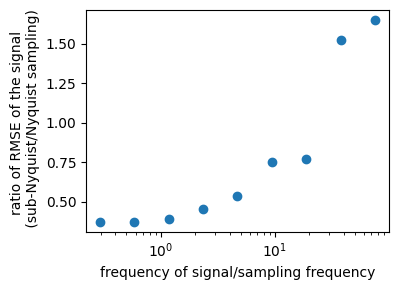

In [72]:
plt.rcParams['figure.figsize'] = [4,3]
plt.rcParams.update({'font.size': 10})

fig, ax = plt.subplots()

# Plot using the ax object
ax.scatter(np.array(initial_frequency)/p, subNyquist_errors / aboveNyquist_error)

# Label axes
ax.set_ylabel('ratio of RMSE of the signal \n (sub-Nyquist/Nyquist sampling)')
ax.set_xlabel('frequency of signal/sampling frequency')

# Set scale
# ax.set_yscale('log')  # Uncomment if needed
ax.set_xscale('log')

# Layout and save
fig.tight_layout()
fig.savefig('../readme_images_src_new/singleWaveStats.jpg', format='jpg', dpi=300)